# Compute the coast line

From the NEMO mask, builds the coastline for nice maps with the real coastline of the ocean model.

Tested with **ORCA2.3**, **eORCA1.2**, **eORCA025**, **eORCA1.4.2** and **paleo ORCA2.3 90Ma**

Olivier Marti - olivier.marti@lsce.ipsl.fr - 2022/08/28

# Licence 
This software is governed by the CeCILL  license under French law and abiding by the rules of distribution of free software.  You can  use, modify and/ or redistribute the software under the terms of the CeCILL license as circulated by CEA, CNRS and INRIA at the following URL "http://www.cecill.info".

Warning, to install, configure, run, use any of Olivier Marti's software or to read the associated documentation you'll need at least one (1) brain in a reasonably working order. Lack of this implement will void any warranties (either express or implied). O. Marti assumes no responsability for errors, omissions, data loss, or any other consequences caused directly or indirectly by the usage of his software by incorrectly or partially configured personal.

In [1]:
import numpy as np, xarray as xr
import nemo
import matplotlib.pyplot as plt
import matplotlib as mpl, cartopy.mpl.ticker
import cartopy.crs as ccrs, cartopy
import importlib, os, platform, datetime
from matplotlib.path import Path
import matplotlib.patches as mpatches
import shapely as shp

# Choose ORCA config

In [2]:
#f_Mask  = '/Users/marti/GRAF/DATA/ORCA2.3_coordinates_mask.nc' ; nperio = 4 ; Model = 'orca2.3' 
#f_Coord = '/Users/marti/GRAF/DATA/coordinates_ORCA2.3.nc'

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.2_mesh_mask.nc' ; nperio = 6 ; Model = 'eorca1.2' ; f_Coord = f_Mask
#f_Coord = '/Users/marti/GRAF/DATA/eORCA1.2_coordinates_mask.nc' ; nperio = 6 ; Model = 'eorca1.2'

#f_Coord = '/Users/marti/GRAF/DATA/coordinates_eORCA1.2.nc' 
#f_Mask = f_Coord

#f_Mask = '/Users/marti/GRAF/DATA/orca2.3_lgm.nc' ; nperio=4 ; Model = 'orca2.3_lgm' ; f_Coord = f_Mask

f_Mask  = '/Users/marti/GRAF/DATA/eORCA025_coordinates_mask.nc' ; nperio=6 ; Model='eORCA025'
f_Coord = '/Users/marti/GRAF/DATA/eORCA025_coordinates.nc'

#f_Mask  = '/Users/marti/Data/MOSAIXLGM/MOSAIX90Ma/ORCA2.3_paleo90MA_coordinates_mask.nc' ; nperio=6 ; Model='ORCA2.3_paleo90MA'
#f_Coord = '/Users/marti/Data/MOSAIXLGM/MOSAIX90Ma/coordinates_paleo90MA.nc'

#f_Mask  = '/Users/marti/Data/PaleoOrca2/new_deepmip_corr_standard_coordinates_mask.nc'
#f_Coord = f_Mask ; nperio=6 ; Model='orca2_deepmip'

#f_Mask  = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_mesh_mask.nc' ; nperio=6.2 ; Model='eorca1.4.2'
#f_Coord = '/Users/marti/GRAF/DATA/eORCA1.4.2_ClosedSeasNew_ModifStraits_domain_cfg.nc' 

## Reading the input file(s)

In [3]:
d_Mask = xr.open_dataset (f_Mask, decode_times=False).squeeze()
if f_Coord == f_Mask : d_Coord = d_Mask
else                 : d_Coord = xr.open_dataset (f_Coord, decode_times=False).squeeze()

udims = nemo.UDIMS
d_Coord = nemo.unify_dims (d_Coord, **udims)
d_Mask  = nemo.unify_dims (d_Mask , **udims)

### Compute grids boxes caracteristics : mask and position of corners

In [4]:
# Masks at center of the grid boxes
if 'tmask' in  d_Mask.variables : 
    maskC = xr.where ( d_Mask.tmask.isel(olevel=0)>0.5, 1.0, 0.0 ) 
if 'mask_T' in  d_Mask.variables : 
    maskC = xr.where ( d_Mask.mask_T>0.5, 1.0, 0.0 ) 
    
maskC = nemo.lbc (maskC, cd_type='T', nperio=nperio)

# Coordinates of the corners of the grid boxes
if 'glamf' in d_Coord.variables : 
    lonE = d_Coord.glamf          
    latE = d_Coord.gphif
if 'nav_lon_grid_T' in d_Coord.variables : 
    lonE = d_Coord.nav_lon_grid_T
    latE = d_Coord.nav_lat_grid_T

### If needed (for NEMO $\ge$ 4.2)

The algorithm needs that periodicity and north folding points are present.
`nemo.lbc_add` adds these points for `nperio` in [4.2, 6.2].

In [5]:
if nperio == 4.2 or nperio == 6.2 :
    maskC = nemo.lbc_add (maskC, cd_type='T', nperio=nperio)
    lonE  = nemo.lbc_add (lonE , cd_type='F', nperio=nperio)
    latE  = nemo.lbc_add (latE , cd_type='F', nperio=nperio)
    if nperio == 4.2 : nperio = 4
    if nperio == 6.2 : nperio = 6
        
lonE = nemo.clo_lon (lonE, 0.)
jpj, jpi = maskC.shape

### Simple test plot

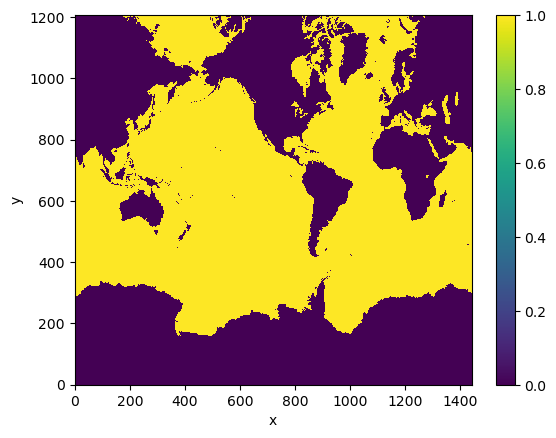

In [6]:
maskC.plot()

## A few utilities

In [7]:
def backward (direction) :
    if direction == 'west'  : backward = 'east'
    if direction == 'east'  : backward = 'west'
    if direction == 'north' : backward = 'south'
    if direction == 'south' : backward = 'north'
    return backward

def toright (direction) :
    if direction == 'west'  : toright = 'north'
    if direction == 'east'  : toright = 'south'
    if direction == 'north' : toright = 'east'
    if direction == 'south' : toright = 'west'
    return toright

def toleft (direction) :
    if direction == 'west'  : toleft  = 'south'
    if direction == 'east'  : toleft  = 'north'
    if direction == 'north' : toleft  = 'east'
    if direction == 'south' : toleft  = 'west'
    return toleft

def next_p (j, i, direction) :
    j_n=j ; i_n=i
    if direction == 'west'  : j_n = j   ; i_n = i-1
    if direction == 'east'  : j_n = j   ; i_n = i+1
    if direction == 'north' : j_n = j+1 ; i_n = i
    if direction == 'south' : j_n = j-1 ; i_n = i
    j_n, i_n = nemo.lbc_index (j_n, i_n, jpj, jpi, nperio=nperio, cd_type='F')
    return j_n, i_n


# Build coastline identifiers
`cote_west` is true if the point is coastal and the next point on his right (on his "west" side) is also a coastal point, on the same coast, with the coast on the left (on the "south")

On most points, we will find 1 possible direction. A few problematic points have 2 possible directions.

In [8]:
def cote_dir_comp (maskC) :
    cote_west  = xr.where(np.logical_and(np.logical_not(maskC.roll(y= 0,x= 0, roll_coords=False)), 
                                                        maskC.roll(y=-1,x= 0, roll_coords=False)),
                          True, False)
    cote_east  = xr.where(np.logical_and(               maskC.roll(y= 0,x=-1, roll_coords=False),
                                         np.logical_not(maskC.roll(y=-1,x=-1, roll_coords=False))),
                          True, False)  
    cote_north = xr.where(np.logical_and(np.logical_not(maskC.roll(y=-1,x= 0, roll_coords=False)), 
                                                        maskC.roll(y=-1,x=-1, roll_coords=False)),
                          True, False) 
    cote_south = xr.where(np.logical_and(               maskC.roll(y= 0,x= 0, roll_coords=False), 
                                         np.logical_not(maskC.roll(y= 0,x=-1, roll_coords=False))),
                          True, False) 
 
    cote_west  = nemo.lbc (cote_west , cd_type='F', nperio=nperio)
    cote_east  = nemo.lbc (cote_east , cd_type='F', nperio=nperio)
    cote_north = nemo.lbc (cote_north, cd_type='F', nperio=nperio)
    cote_south = nemo.lbc (cote_south, cd_type='F', nperio=nperio)

    cote_dir = xr.concat ([cote_west, cote_east, cote_north, cote_south], dim='direction')
    cote_dir = cote_dir.assign_coords (direction=['west', 'east', 'north', 'south'])
    cote_dir.name = 'Direction'
    return cote_dir
    
cote_dir   = cote_dir_comp (maskC)
cote_total = cote_dir.sum (dim='direction')
coastal_points = np.where (cote_total>0)

### Plot the number of possible direction(s) at each point

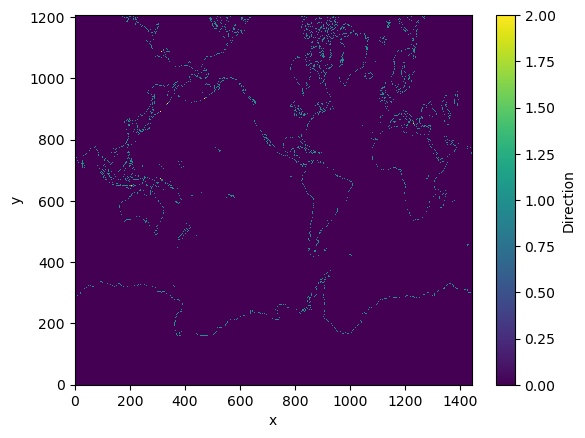

In [9]:
cote_dir.sum(dim='direction').plot(cmap='viridis')

## The real work

In [10]:
importlib.reload (nemo)

## Compute directions
cote_dir = cote_dir_comp (maskC)

## Count the number of directions for each point
cote_total = cote_dir.sum (dim='direction')

## We start from 0
i_start = 0

# Get first coastal point to start
j_zero, i_zero = nemo.lbc_index (coastal_points[0][i_start], coastal_points[1][i_start], jpj, jpi, nperio=nperio, cd_type='F')
print ( f'coastal points:{len(coastal_points[0])} / starting point: jzero={j_zero.item()}, i_zero={i_zero.item()}')
j_s, i_s = j_zero, i_zero

# Intialize the list of points indexes, points longitudes and latitudes
list_lat    = [ latE.values[j_zero, i_zero] ]
list_lon    = [ lonE.values[j_zero, i_zero] ]
list_idx    = [            [j_zero, i_zero] ]
list_j = [j_zero] ; list_i = [i_zero]

# To numerate land masses
i_land      = 1
list_land   = [i_land]  # To numerate land masses
list_inner  = [0] # 1 if inner water body (lake, closed sea)

# Bad trick to have the first land mass (Antartica) in the same longitude range than the other
if 'orca2' in Model : list_lon = [ nemo.clo_lon(lonE.values[j_zero, i_zero], 100.0) ] 

# Initialize indexes and indicators
# lastd is the last used direction
j_p, i_p = j_zero, i_zero ; new=True ; lastd='None' 

n = 0
while True :
    n += 1
    ## new == True if we start to circle a new land mass
    if new : j_s, i_s = j_p, i_p
    #print ( f'{n=:<5d} {j_p=:<4d} {i_p=:<4d} {lastd=:<5s} cote_total:{cote_total[j_p, i_p].values:<2d}', end=' ')

    found=False ; new=False ; nextd = 'None' ;

    # Always tries to turn right first, with respect to direction of previous move.
    order = ['north', 'west', 'south', 'east'] # Active if last_d == None
    if lastd == 'west'  : order = ['north', 'west' , 'south', 'east' ]
    if lastd == 'east'  : order = ['south', 'east' , 'north', 'west' ]
    if lastd == 'north' : order = ['east' , 'north', 'west' , 'south']
    if lastd == 'south' : order = ['west' , 'south', 'east' , 'north']
        
    # Search the direction of the next point. We must not go backward
    for direction in order :
        if not found and cote_dir.sel (direction=direction) [j_p, i_p] : 
            found = True ; nextd=direction
            j_n, i_n = next_p (j_p, i_p, direction)
                     
    #print ( f'nextd:{nextd:<6s} lon:{lonE[j_n, i_n].values:<5.1f} lat:{latE[j_n, i_n].values:<5.1f} list_land:{list_land[-1]:4<d}', end='') 
    
    if found : 
        cote_dir.sel (direction=nextd)[j_p, i_p] = False
        cote_dir = nemo.lbc (cote_dir, nperio=nperio, cd_type='F')
        list_lon.append  ( lonE.values[j_n, i_n] )
        list_lat.append  ( latE.values[j_n, i_n] )
        list_idx.append  ( [j_n, i_n] )
        list_j.append (j_p) ; list_i.append (j_p)
        list_land.append ( i_land )
        list_inner.append ( 0)
        list_lon [-1] = nemo.clo_lon (list_lon[-1], list_lon[-2]) # Avoid too much jump across periodicity
        j_p, i_p = j_n, i_n
        lastd = nextd ; nextd='None' ; new=False
        #print ( f' list_land:{list_land[-1]:<4d}' )

    else : # We have circled around the land mass. Let jump to a new one
        # Insert a dummy point to break the line
        list_lon.append (np.nan)
        list_lat.append (np.nan)
        list_idx.append ( [-99, -99] )
        list_j.append (-99) ; list_i.append (-99)
        list_land.append (0)
        list_inner.append (0)
       
        cote_total = cote_dir.sum (dim='direction')
        # Search if non addressed coastal points still exists
        nn = np.where (cote_total>=1)
        if len (nn[0]) == 0 :
            print ()
            print ('All points processed')
          
            break
        else :
            # Takes the first non-addressed coastal point
            #print ()
            new=True  # Starting a new land mass
            lastd='None'
            # Take the first point in nn. Put it back in the 'inner' ORCA domain
            # (not at the periodicity or north pole folding).
            j_p, i_p = nemo.lbc_index (nn[0][0], nn[1][0], jpj, jpi, nperio, 'F')
            print ( f'New start {n=:<5d} {j_p=:<4d} {i_p=:<4d} cote_total:{cote_total[j_p, i_p].values} cote_dir:{cote_dir[:, j_p, i_p].values} liste_land:{list_land[-2]}' )
            i_land += 1
            list_lon.append  ( nemo.clo_lon (lonE.values[j_p, i_p], 0.) )
            list_lat.append  ( latE.values[j_p, i_p] )
            list_idx.append ([j_p, i_p])
            list_j.append (j_p) ; list_i.append (j_p)
            list_land.append (i_land)
            list_inner.append (0)
        
print ( f'Length : {len(list_lon)} - Land masses : {i_land}' )

list_lon    = np.transpose (np.array(list_lon))
list_lat    = np.transpose (np.array(list_lat))
list_idx    = np.transpose (np.array(list_idx))
list_j      = np.array (list_j) ; list_i = np.array ( list_i )
list_land   = np.array (list_land)
list_inner  = np.array (list_inner)

coastal points:30307 / starting point: jzero=158, i_zero=374
New start n=3387  j_p=238  i_p=387  cote_total:1 cote_dir:[False  True False False] liste_land:1
New start n=3396  j_p=243  i_p=729  cote_total:1 cote_dir:[False  True False False] liste_land:2
New start n=3407  j_p=298  i_p=786  cote_total:1 cote_dir:[False  True False False] liste_land:3
New start n=3412  j_p=313  i_p=367  cote_total:1 cote_dir:[False  True False False] liste_land:4
New start n=3421  j_p=320  i_p=361  cote_total:1 cote_dir:[False  True False False] liste_land:5
New start n=3426  j_p=321  i_p=1342 cote_total:1 cote_dir:[False  True False False] liste_land:6
New start n=3431  j_p=324  i_p=358  cote_total:1 cote_dir:[False  True False False] liste_land:7
New start n=3436  j_p=330  i_p=884  cote_total:1 cote_dir:[False  True False False] liste_land:8
New start n=3441  j_p=332  i_p=885  cote_total:1 cote_dir:[False  True False False] liste_land:9
New start n=3446  j_p=336  i_p=120  cote_total:1 cote_dir:[False  

## Find inland water bodies

In [11]:
def IsIn (lon, lat, lon0=0, lat0=90) : 
    '''
    True if North pole is in the polygon
    Uses cumul of vector product of adjacent pairs
    '''
    dlon=lon-lon0 ; dlat=lat-lat0
    prod=0.
    for i in np.arange(len(dlon)) :
        dp =  (dlon[i-1]*dlat[i]-dlat[i-1]*dlon[i])
        prod = prod + dp
    return prod < 0.

n_mass = np.max (list_land)

for n_m in np.arange(n_mass)+1 :
    idx = np.where (list_land == n_m)
    nn = len( idx[0] )
    if nn > 0 : 
        lon = np.array (list_lon[idx]) ; lat = np.array (list_lat[idx])
        indic = IsIn (lon, lat)
        print ( f'{n_m=:<3d}  lon mean: {lon.mean():<-6.1f} lat mean : {lat.mean():<-6.1f}   {indic=}' )
        if indic : 
            #list_lon   [idx[0]] = lon[::-1]
            #list_lat   [idx[0]] = lat[::-1]
            list_inner [idx[0]] = 1

n_m=1    lon mean: -12.5  lat mean : -71.5    indic=False
n_m=2    lon mean: 169.7  lat mean : -73.5    indic=False
n_m=3    lon mean: -104.8 lat mean : -73.1    indic=False
n_m=4    lon mean: -90.5  lat mean : -68.9    indic=False
n_m=5    lon mean: 164.7  lat mean : -67.4    indic=False
n_m=6    lon mean: 163.2  lat mean : -66.8    indic=False
n_m=7    lon mean: 48.5   lat mean : -66.7    indic=False
n_m=8    lon mean: 162.5  lat mean : -66.4    indic=False
n_m=9    lon mean: -66.0  lat mean : -65.8    indic=False
n_m=10   lon mean: -65.8  lat mean : -65.6    indic=False
n_m=11   lon mean: 103.0  lat mean : -65.2    indic=False
n_m=12   lon mean: -63.5  lat mean : -64.6    indic=False
n_m=13   lon mean: -62.4  lat mean : -64.3    indic=False
n_m=14   lon mean: -57.8  lat mean : -64.1    indic=False
n_m=15   lon mean: -55.9  lat mean : -63.3    indic=False
n_m=16   lon mean: -56.5  lat mean : -63.1    indic=False
n_m=17   lon mean: -62.5  lat mean : -63.0    indic=False
n_m=18   lon m

In [12]:
## Test

#ist_lon = nemo.clo_lon (list_lon, 0)


## Very simple demo plot
With no projection

Text(0.5, 1.0, 'eORCA025')

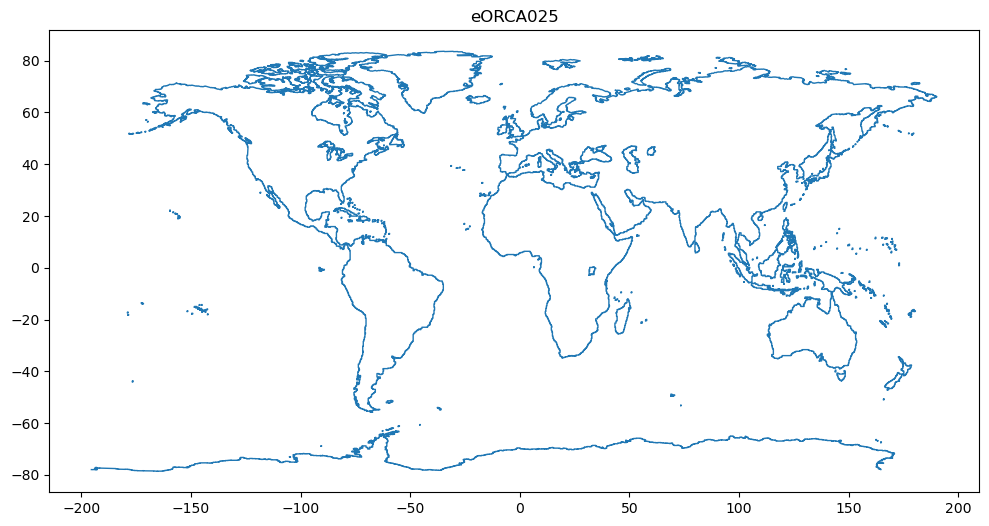

In [13]:
fig = plt.figure (figsize=(12,6))

ax = fig.add_subplot (111)
nn=1571
ax.plot (list_lon[:], list_lat[:], linewidth=1)
ax.set_title (Model)

# Build shapely structure

## Build land masses and inner water bodies

In [14]:
n_mass  = list_land.max().item()
holes   = []
corners = []
for nm in np.arange(1,n_mass+1) :
#for nm in np.arange (9,10) :
#for nm in [9,] :
    pts = np.where (list_land == nm)[0]
    # pts = pts[::-1]
    # fill Antartica
    if nm == 1 : 
        poly_corners = np.stack ( [list_lon[pts], list_lat[pts]]).T
        for pt in pts[::-1] : 
            poly_corners = np.row_stack ( [poly_corners, np.array([list_lon[pt], -90.])])
        poly_corners = np.row_stack ( [poly_corners, poly_corners[0]])
    if nm > 1 : 
        pts = np.append (pts, pts[0] )
        poly_corners = np.stack ( [list_lon[pts], list_lat[pts]]).T
    if list_inner[pts][0] == 1 :
        hole = poly_corners
        holes.append (poly_corners)
    else : 
        corners.append (poly_corners)

In [15]:
n_corner = len(corners)
n_hole   = len(holes)

polys = []
# Loop on water bodies
for nc in np.arange (n_corner) :
    in_hole = []
    poly = shp.Polygon (corners[nc])
    # Loop on inner water bodies
    for nh in np.arange (n_hole) :
        if shp.Point (holes[nh][0]).within(poly):
            in_hole.append (holes[nh])
        poly = shp.Polygon (corners[nc], in_hole)
    polys.append (poly)

coast_shp = shp.MultiPolygon (polys)

coast_geo = shp.to_geojson (coast_shp, indent=None,)
fic = open ( f'{Model}_coastline.json', 'w')
fic.write (coast_geo)
fic.close ()

## Build cartopy feature

In [16]:
coast_poly = cartopy.feature.ShapelyFeature (coast_shp, ccrs.PlateCarree (central_longitude=0), facecolor='none')

In [29]:
CenLon = 0.01

#ProjPlot=ccrs.PlateCarree(central_longitude=CenLon)
ProjPlot=ccrs.Robinson(central_longitude=CenLon)
#ProjPlot=ccrs.Orthographic(central_longitude=CenLon, central_latitude=-90)
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=90)
#ProjPlot=ccrs.AzimuthalEquidistant      (central_longitude=CenLon)
#ProjPlot=ccrs.InterruptedGoodeHomolosine(central_longitude=CenLon)
#ProjPlot=ccrs.LambertAzimuthalEqualArea (central_longitude=CenLon)
#ProjPlot=ccrs.AlbersEqualArea           (central_longitude=CenLon), 
#ProjPlot=ccrs.Stereographic             (central_longitude=CenLon, central_latitude=40)
#ProjPlot=ccrs.Mollweide                 (central_longitude=CenLon)
#ProjPlot=ccrs.NorthPolarStereo          (central_longitude=CenLon)
#ProjPlot=ccrs.LambertConformal          (central_longitude=CenLon, cutoff=-30)
#ProjPlot=ccrs.Orthographic              (central_longitude=CenLon, central_latitude=90)
#ProjPlot=ccrs.EckertVI                  (central_longitude=CenLon)
#ProjPlot=ccrs.EquidistantConic          (central_longitude=CenLon)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude=60.0, central_rotated_longitude=lon0)
#ProjPlot=ccrs.RotatedPole      (pole_longitude=CenLon, pole_latitude= 0.0, central_rotated_longitude=lon0)

## Plot with projection

Warning : in recent version of Matpotlib, somme projection may fails. Limited to projection showing all the globe (Robinson, Molleweide)

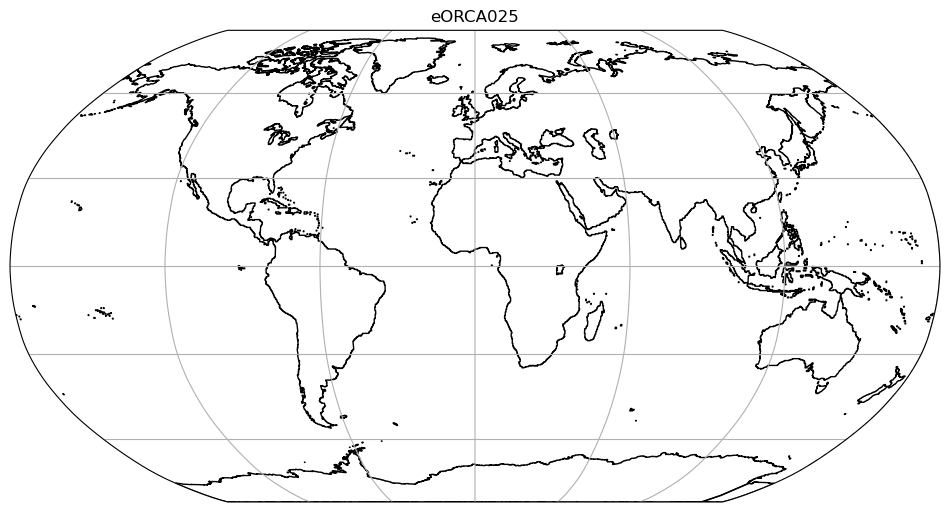

In [30]:
fig = plt.figure(figsize=(12,12))
ProjIn = ccrs.PlateCarree(central_longitude=0)

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (Model)
ax.add_feature (coast_poly, facecolor='none')
ax.gridlines  ()

## Plot with filling

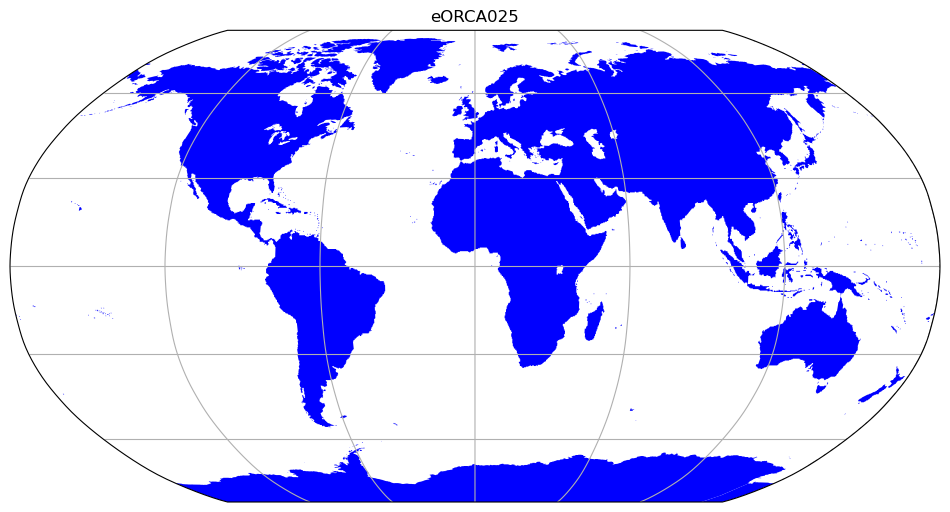

In [31]:
fig = plt.figure(figsize=(12,12))
ProjIn = ccrs.Geodetic ()

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (Model)
ax.add_feature (coast_poly, facecolor='blue')
ax.gridlines  ()

#for nn in np.arange (np.max(list_land)) :
#    xlon = np.mean (list_lon[np.where(list_land==nn)])
#    ylat = np.mean (list_lat[np.where(list_land==nn)])
#    ax.annotate (str(nn), xy=[xlon,ylat], xycoords=ProjIn._as_mpl_transform(ax), fontsize='large', ha='center', va='center')
    

## Using a path 
Work with all projection for the coastline

With filling, may work, or not, depending on the projection. Better with limited area.

In [28]:
codes = np.where (np.isnan(list_lon), Path.MOVETO, Path.LINETO)
codes[0] = Path.MOVETO
path = Path (np.stack([list_lon, list_lat]).T, codes)

/Users/marti/mambaforge/envs/FULL/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


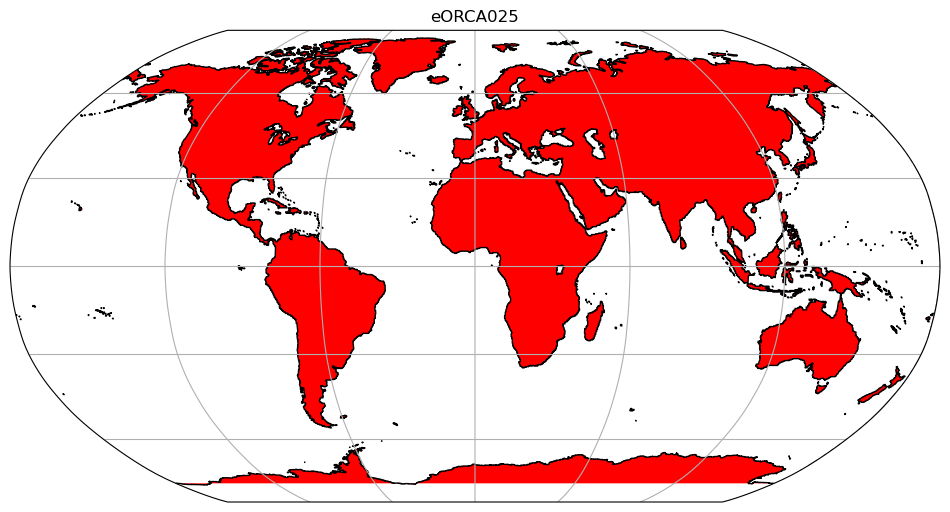

In [21]:
fig = plt.figure(figsize=(12,12))
ProjIn = ccrs.PlateCarree(central_longitude=0)

ax = fig.add_subplot (111, projection=ProjPlot)

ax.set_title (Model)
ax.set_global ()
patch = mpatches.PathPatch (path, facecolor='red', lw=1, transform=ProjIn)
ax.add_patch (patch)
ax.gridlines  ()

# Write the result

In [22]:
list_lon = xr.DataArray (list_lon, dims = ['coastal_point',])
list_lat = xr.DataArray (list_lat, dims = ['coastal_point',])
list_lon.attrs.update ({'name':'Longitude', 'units':'degrees_east' , 'long_name':'Longitude of coast line'})
list_lat.attrs.update ({'name':'Latitude' , 'units':'degrees_north', 'long_name':'Latitude of coat line'  })

list_land = xr.DataArray ( list_land, dims = ['coastal_point',])
list_land.attrs.update ( {'long_name':'Land mass identifier'})

list_inner = xr.DataArray ( list_inner, dims = ['coastal_point', ])
list_inner.attrs['long_name'] = 'Inner water body (lake, closed sea, ...) indicator. 1 if inner water body, 0 else'

list_j = xr.DataArray ( list_j, dims = ['coastal_point', ] )
list_i = xr.DataArray ( list_i, dims = ['coastal_point', ] )
list_j.attrs.update ({'name':'IndexJ', 'long_name':'Index J'})
list_i.attrs.update ({'name':'IndexI', 'long_name':'Index I'})

OuFile = Model + '_' + 'coastline.nc'
list_geo = xr.Dataset ( {'lon_coast':list_lon, 'lat_coast':list_lat, 'land_mass':list_land, 'inner_water_body':list_inner, 
                          'IndexJ':list_j, 'IndexI':list_i})
list_geo.attrs.update ({'Description':'Coordinates of the coastline', 'File':OuFile,
                        'title':'Coordinates of the coastline', 'Conventions':"CF-1.6", 'source':"IPSL Earth system model",
                        'group':"ICMC IPSL Climate Modelling Center", 'Institution':"IPSL https://www.ipsl.fr", 'associatedFiles':[f_Coord, f_Mask],
                        'directory':os.getcwd (), 'description':"Generated with CoastLine.ipynb", 
                        'created':str(datetime.datetime.now().strftime('%A %d %B %Y @ %H:%M %Z')),
                        'HOSTNAME':platform.node (), 'LOGNAME':os.getlogin (), 'Python':f"Python version {platform.python_version ()}",
                        'OS':f'{platform.system()} {platform.release ()}', 'hardware':platform.machine () })

In [23]:
if os.path.exists (OuFile) : 
    os.remove (OuFile)

list_geo.to_netcdf ( OuFile, mode='w', encoding={
      "lon_coast"        : {'dtype': 'float32'},
      "lat_coast"        : {'dtype': 'float32'},
      "land_mass"        : {'dtype': 'int32'  },
      "inner_water_body" : {'dtype': 'int32'  },
      "IndexI"           : {'dtype': 'int32'  },
      "IndexJ"           : {'dtype': 'int32'  },
} )

In [24]:
list_geo

<xarray.Dataset> Size: 2MB
Dimensions:           (coastal_point: 31366)
Dimensions without coordinates: coastal_point
Data variables:
    lon_coast         (coastal_point) float64 251kB 164.6 164.7 ... -107.5 nan
    lat_coast         (coastal_point) float64 251kB -77.98 -77.94 ... 68.21 nan
    land_mass         (coastal_point) int64 251kB 1 1 1 1 1 ... 528 528 528 0
    inner_water_body  (coastal_point) int64 251kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    IndexJ            (coastal_point) int64 251kB 158 158 159 ... 1201 1201 -99
    IndexI            (coastal_point) int64 251kB 374 158 159 ... 1201 1201 -99
Attributes: (12/16)
    Description:      Coordinates of the coastline
    File:             eORCA025_coastline.nc
    title:            Coordinates of the coastline
    Conventions:      CF-1.6
    source:           IPSL Earth system model
    group:            ICMC IPSL Climate Modelling Center
    ...               ...
    created:          Thursday 07 March 2024 @ 12:11 
    HOSTNAME:         lsce5138.lsce.ipsl.fr
    LOGNAME:          root
    Python:           Python version 3.11.8
    OS:               Darwin 23.2.0
    hardware:         x86_64